# Reporte de Clase 06

## Objetivos  
- **Comprender el manejo de riesgo de tasas:** Presentar los fundamentos del riesgo de tasa de interés y la forma en que se puede cuantificar y gestionar utilizando medidas como la duración y la convexidad.  
- **Analizar estrategias de spread y convergencia:** Revisar cómo comparar bonos de diferentes vencimientos para identificar oportunidades de arbitraje o convergencia, basándose en diferencias de tasas.  
- **Aplicación práctica con Python:** Implementar un caso práctico en el que se descarguen datos reales de bonos del Tesoro desde el FRED (Federal Reserve St Louis.), se calculen medidas de riesgo y se determine el mark-to-market diario, acompañando de un análisis de sensbilidad utilizando fórmulas de duración y convexidad.
- **Visualizar la curva de bonos:** Graficar la evolución y la estructura de la curva de rendimientos en distintos plazos, enfatizando la dinámica de convergencia entre estos.


## Contenido  
Se parte de la introducción al riesgo de tasas explicando que la sensibilidad del precio de un bono ante cambios en la tasa se mide a través de:  

- **Duración (D):** Que indica la variación porcentual en el precio ante un cambio unitario en la tasa.  
- **Convexidad (C):** Que permite ajustar la aproximación lineal para capturar la curvatura real en la relación precio-tasa.  

La variación en el precio de un bono se puede aproximar con la fórmula:  

$$
\Delta P \approx - D \cdot P \cdot \Delta y + \frac{1}{2} \cdot C \cdot P \cdot (\Delta y)^2
$$

donde:  
- $ P $ es el precio del bono  
- $ \Delta y $ es la variación en la tasa de interés  
- $ D $ es la duración  
- $ C $ es la convexidad  

Además, se introduce el cómputo de la diferencia de fechas en frecuencia anual utilizando una convención (por ejemplo, 360 o 365 días), lo que permite calcular adecuadamente los cambios diarios en un marco temporal anualizado.

Por otro lado, se analiza la estrategia de **spread o convergencia de tasas**. Esta estrategia consiste en comparar bonos de similar calidad crediticia pero de distintos vencimientos. La idea es aprovechar que, en condiciones de mercado, la estructura de plazos tiende a converger o presentar variaciones predecibles que pueden generar oportunidades de arbitraje.



Cálculo del mark-to-market diario y la visualización de la curva de bonos.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calcular_duracion_convexidad_dv01(cupon, ytm, vencimiento, nominal=100):
    """
    Calcula duración modificada, convexidad y DV01 para un bono dado.
    
    Parameters:
        cupon (float): tasa de cupón anual.
        ytm (float): yield to maturity anual.
        vencimiento (int): años hasta vencimiento.
        nominal (float): valor nominal del bono.
    
    Returns:
        tuple: precio, duración modificada, convexidad, DV01
    """
    # Crear array de flujos
    flujos_cupones = np.array([cupon * nominal] * vencimiento)
    flujo_final = nominal + (cupon * nominal)  # Último flujo incluye el cupón + nominal
    flujos = np.zeros(vencimiento)
    
    # Llenar con cupones y añadir el principal al final
    flujos[:vencimiento-1] = flujos_cupones[:vencimiento-1]
    flujos[vencimiento-1] = flujo_final
    
    # Tiempos de descuento
    tiempos = np.arange(1, vencimiento + 1)
    
    # Factores de descuento
    descuento = (1 + ytm)**(-tiempos)
    
    # Valor presente de cada flujo
    vp = flujos * descuento
    
    # Precio del bono
    precio = vp.sum()
    
    # Duración de Macaulay
    duracion_macaulay = (tiempos * vp).sum() / precio
    
    # Duración modificada
    duracion_modificada = duracion_macaulay / (1 + ytm)
    
    # Convexidad
    convexidad = (tiempos * (tiempos + 1) * vp).sum() / (precio * (1 + ytm)**2)
    
    # DV01 (Valor de un punto base)
    dv01 = duracion_modificada * precio * 0.0001
    
    return precio, duracion_modificada, convexidad, dv01

def calcular_variacion_precio(precio, duracion_modificada, convexidad, variacion_tasa):
    """
    Calcula la variación en el precio ante un cambio en la tasa de interés.
    
    Parameters:
        precio (float): precio actual del bono.
        duracion_modificada (float): duración modificada del bono.
        convexidad (float): convexidad del bono.
        variacion_tasa (float): cambio en la tasa de interés (en decimal, p.ej. 0.01 para 1%).
        
    Returns:
        tuple: nueva estimación de precio, cambio en precio, cambio porcentual
    """
    # Aproximación de primer orden (solo duración)
    cambio_precio_duracion = -duracion_modificada * precio * variacion_tasa
    
    # Aproximación de segundo orden (duración + convexidad)
    cambio_precio_convexidad = 0.5 * convexidad * precio * (variacion_tasa**2)
    
    # Cambio total en precio
    cambio_precio_total = cambio_precio_duracion + cambio_precio_convexidad
    
    # Nuevo precio estimado
    nuevo_precio = precio + cambio_precio_total
    
    # Cambio porcentual
    cambio_porcentual = (cambio_precio_total / precio) * 100
    
    return nuevo_precio, cambio_precio_total, cambio_porcentual


In [3]:

# Ejemplo de cálculo para un bono a 10 años
cupon = 0.04  # 4% anual
vencimiento = 10  # 10 años
ytm = 0.045  # Suponiendo una YTM del 4.5%

# En un caso real, usarías tu dataframe:
# ytm = df_selected['10 Años'].iloc[-1]/100

# Calcular métricas del bono
precio_inicial, duracion_inicial, convexidad_inicial, dv01 = calcular_duracion_convexidad_dv01(cupon, ytm, vencimiento)

print(f"Precio del bono: {precio_inicial:.2f}")
print(f"Duración modificada: {duracion_inicial:.4f}")
print(f"Convexidad: {convexidad_inicial:.6f}")
print(f"DV01: {dv01:.4f}")


Precio del bono: 96.04
Duración modificada: 8.0361
Convexidad: 79.517681
DV01: 0.0772


In [4]:

# Calcular el impacto de un cambio en la tasa de 50 puntos básicos (0.5%)
variacion_tasa = 0.005  # 50 bps
precio_nuevo, cambio_precio, cambio_porcentual = calcular_variacion_precio(
    precio_inicial, duracion_inicial, convexidad_inicial, variacion_tasa
)
precio, duracion, convexidad, dv01 = calcular_duracion_convexidad_dv01(cupon, ytm + variacion_tasa, vencimiento)
print("\nImpacto de un aumento de 50 puntos básicos en la tasa:")
print(f"Nuevo precio estimado: {precio_nuevo:.2f}")
print(f"Nuevo precio valorizado: {precio:.2f}")
print(f"Cambio en precio: {cambio_precio:.2f}")
print(f"Cambio porcentual: {cambio_porcentual:.2f}%")

# También podemos calcular para una disminución en la tasa
precio_nuevo_baja, cambio_precio_baja, cambio_porcentual_baja = calcular_variacion_precio(
    precio_inicial, duracion_inicial, convexidad_inicial, -variacion_tasa
)
precio, duracion, convexidad, dv01 = calcular_duracion_convexidad_dv01(cupon, ytm - variacion_tasa, vencimiento)
print("\nImpacto de una disminución de 50 puntos básicos en la tasa:")
print(f"Nuevo precio estimado: {precio_nuevo_baja:.2f}")
print(f"Nuevo precio valorizado: {precio:.2f}")
print(f"Cambio en precio: {cambio_precio_baja:.2f}")
print(f"Cambio porcentual: {cambio_porcentual_baja:.2f}%")


Impacto de un aumento de 50 puntos básicos en la tasa:
Nuevo precio estimado: 92.28
Nuevo precio valorizado: 92.28
Cambio en precio: -3.76
Cambio porcentual: -3.92%

Impacto de una disminución de 50 puntos básicos en la tasa:
Nuevo precio estimado: 100.00
Nuevo precio valorizado: 100.00
Cambio en precio: 3.95
Cambio porcentual: 4.12%


In [5]:
# Cargamos los datos recientes (últimas 3 semanas)
try:
    ruta = "data/yield_curve_historical_usa.xlsx"
    df = pd.read_excel(ruta, parse_dates=['date'], index_col='date')
except:
    url = "https://github.com/ECFIN-USACH/economia-financiera/raw/main/data/yield_curve_historical_usa.xlsx"
    df = pd.read_excel(url, parse_dates=['date'], index_col='date') 

df = df[['1 Año', '2 Años', '3 Años', '5 Años', '7 Años', '10 Años', '20 Años', '30 Años']]

In [6]:

# Filtramos los últimos 21 días (3 semanas)
df_recent = df.tail(21)
df_recent.head()

selected_tenors = ['1 Año', '3 Años', '10 Años']
df_selected = df_recent[selected_tenors]
df_selected.head()

,1 Año,3 Años,10 Años
date,,,
2025-02-20,4.20,4.27,4.50
2025-02-21,4.15,4.19,4.42
2025-02-24,4.15,4.17,4.40
2025-02-25,4.12,4.08,4.30
2025-02-26,4.12,4.04,4.25


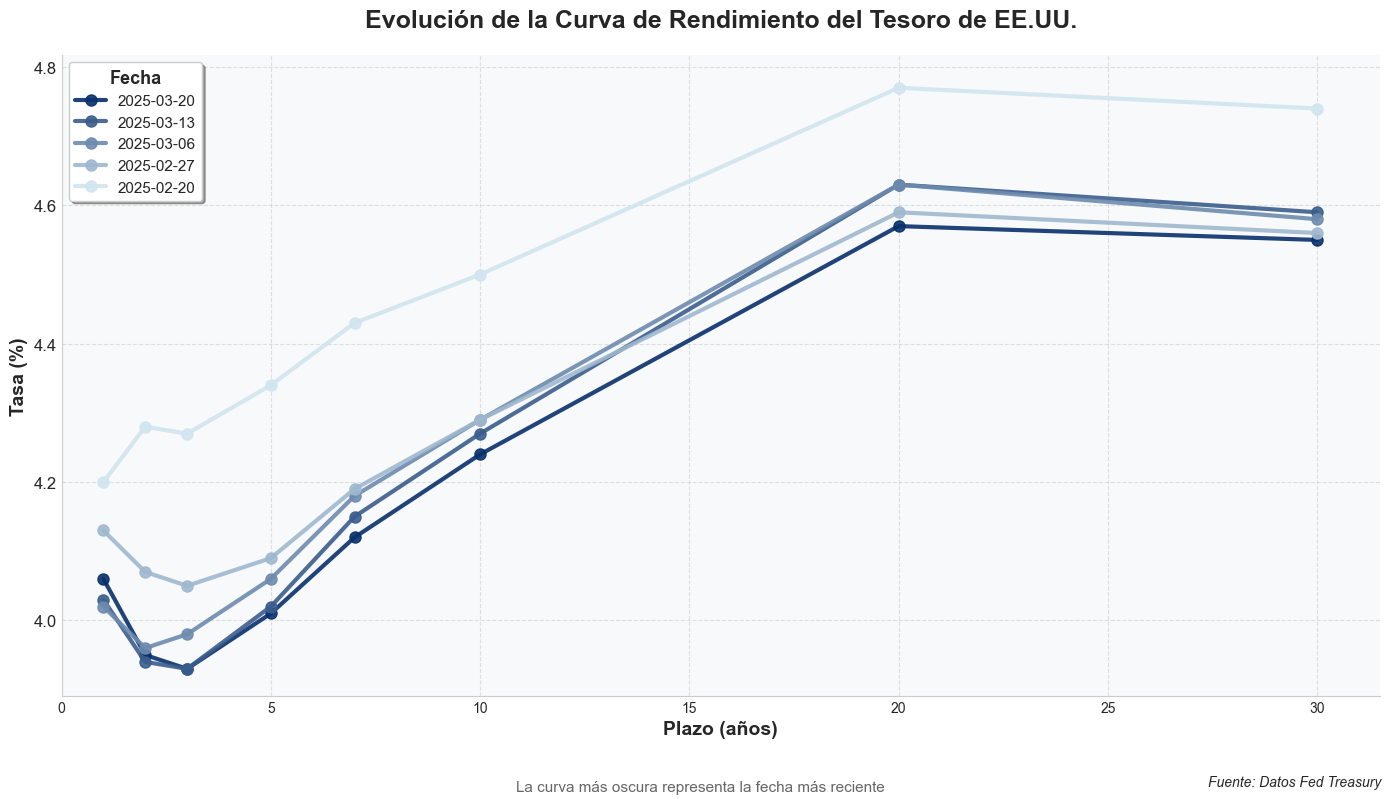

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_yield_curves_improved(df, step=5):
    """
    Grafica las curvas de rendimiento del tesoro para la fecha más reciente
    y cada 5 observaciones hacia atrás.
    
    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame con fechas como índice y tenores como columnas
    step : int, opcional
        Número de observaciones a saltar entre curvas, por defecto 5
    """
    # Obtener todas las fechas disponibles, desde la más reciente hasta la más antigua
    dates = df.index.tolist()
    dates.reverse()  # Más reciente primero
    
    # Seleccionar fechas a intervalos de 'step'
    selected_dates = [dates[i] for i in range(0, len(dates), step)]
    n_curves = len(selected_dates)
    
    # Convertir nombres de columnas a valores numéricos (años)
    tenor_mapping = {
        '1 Mes': 1/12,
        '3 Meses': 3/12,
        '6 Meses': 6/12,
        '1 Año': 1,
        '2 Años': 2,
        '3 Años': 3,
        '5 Años': 5,
        '7 Años': 7,
        '10 Años': 10,
        '20 Años': 20,
        '30 Años': 30
    }
    
    # Crear figura con estilo mejorado
    plt.figure(figsize=(14, 8))
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Crear paleta de colores azules (de claro a oscuro)
    # Ahora el más reciente es el más oscuro
    blues = LinearSegmentedColormap.from_list("Blues", ["#D1E5F0", "#08306B"], N=n_curves)
    
    # Graficar cada curva
    for i, date in enumerate(selected_dates):
        # El color más oscuro es para la fecha más reciente (i=0)
        color = blues(1 - i/(n_curves-1) if n_curves > 1 else 0.5)
        
        # Preparar datos para esta fecha
        x_values = [tenor_mapping[col] for col in df.columns]
        y_values = df.loc[date].values
        
        # Graficar con estilo mejorado
        plt.plot(x_values, y_values, marker='o', linestyle='-', linewidth=3, markersize=8, 
                 color=color, label=date.strftime('%Y-%m-%d'), alpha=0.9)
    
    # Configurar ejes y etiquetas con mejor estilo
    plt.xlabel('Plazo (años)', fontsize=14, fontweight='bold')
    plt.ylabel('Tasa (%)', fontsize=14, fontweight='bold')
    plt.title('Evolución de la Curva de Rendimiento del Tesoro de EE.UU.', 
              fontsize=18, fontweight='bold', pad=20)
    
    # Personalizar el eje X para mostrar mejor los valores
    # x_ticks = [tenor_mapping[col] for col in df.columns]
    # x_labels = ['1M', '3M', '6M', '1A', '2A', '3A', '5A', '7A', '10A', '20A', '30A']
    # plt.xticks(x_ticks, x_labels, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Agregar cuadrícula para mejor visualización
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Configurar límites de los ejes para mejor visualización
    plt.xlim(0, tenor_mapping[df.columns[-1]] * 1.05)
    
    # Calcular límites basados en los datos seleccionados
    selected_data = df.loc[selected_dates]
    min_rate = selected_data.min().min() * 0.99
    max_rate = selected_data.max().max() * 1.01
    plt.ylim(min_rate, max_rate)
    
    # Agregar leyenda mejorada
    legend = plt.legend(title='Fecha', loc='upper left', frameon=True, 
               fancybox=True, shadow=True, fontsize=11)
    plt.setp(legend.get_title(), fontsize=13, fontweight='bold')
    
    # Agregar anotaciones y mejorar apariencia
    plt.figtext(0.99, 0.01, 'Fuente: Datos Fed Treasury', 
                ha='right', fontsize=10, style='italic')
    
    # Agregar una explicación del gráfico
    plt.annotate('La curva más oscura representa la fecha más reciente', 
                 xy=(0.5, 0.01), xycoords='figure fraction', 
                 ha='center', fontsize=11, alpha=0.7)
    
    # Personalizar bordes
    for spine in plt.gca().spines.values():
        spine.set_linewidth(0.8)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Mejorar el fondo del gráfico
    plt.gca().set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    plt.show()
    
    return plt.gcf()


# Ejemplo de uso:
plot_yield_curves_improved(df_recent)

In [21]:


def improved_bond_price(y: float, coupon: float, face_value: float,
                          purchase_date: pd.Timestamp, settlement_date: pd.Timestamp,
                          maturity_years: int, day_count_basis: int = 365) -> float:
    """
    Calcula el precio de un bono descontando sus flujos de caja
    considerando la diferencia en días entre la fecha de valoración (settlement_date) 
    y la fecha del próximo cupón, para anualizar los exponentes según la base de conteo 
    (por ejemplo, 365 o 360 días).

    Se asume que:
      - El bono paga cupones de forma anual, en el aniversario de la fecha de compra.
      - 'maturity_years' es el número total de cupones (años) que tenía el bono al momento de la compra.

    Parámetros:
      - y: yield (TIR) actual en formato decimal (por ejemplo, 0.03 para 3%).
      - coupon: pago del cupón en valor absoluto (por ejemplo, face_value * tasa_cupon).
      - face_value: valor nominal del bono.
      - purchase_date: fecha de compra original (pd.Timestamp).
      - settlement_date: fecha de valoración actual (pd.Timestamp).
      - maturity_years: cantidad de cupones anuales originalmente remanentes.
      - day_count_basis: base para anualizar (365 o 360). Valor predeterminado 365.
    
    Retorna:
      - Precio calculado del bono.
    """
    # Determinar la fecha del próximo cupón usando el aniversario de la fecha de compra
    try:
        coupon_anniversary = purchase_date.replace(year=settlement_date.year)
    except ValueError:
        # Manejo de casos como el 29 de febrero en años no bisiestos
        coupon_anniversary = purchase_date.replace(year=settlement_date.year, day=28)
    
    # Si el aniversario ya pasó o es hoy, el próximo cupón será el del año siguiente
    if coupon_anniversary <= settlement_date:
        try:
            next_coupon_date = purchase_date.replace(year=settlement_date.year + 1)
        except ValueError:
            next_coupon_date = purchase_date.replace(year=settlement_date.year + 1, day=28)
    else:
        next_coupon_date = coupon_anniversary

    # Cálculo de la fracción del año hasta el próximo cupón (según la convención de días)
    days_to_next_coupon = (next_coupon_date - settlement_date).days
    fraction_first_coupon = days_to_next_coupon / day_count_basis

    # Se asume que se cuentan todos los cupones remanentes a partir de la fecha de compra
    n_coupons = maturity_years

    price = 0.0

    # Descuento del primer cupón usando la fracción del periodo
    price += coupon / ((1 + y) ** fraction_first_coupon)

    # Descuento de los cupones intermedios
    for i in range(1, n_coupons):
        # Tiempo (en años fraccional) hasta el i-ésimo cupón:
        t = fraction_first_coupon + i
        price += coupon / ((1 + y) ** t)

    # Descuento del pago final (último cupón + nominal)
    t_final = fraction_first_coupon + n_coupons
    price += (coupon + face_value) / ((1 + y) ** t_final)

    return price


def calculate_bond_price_timeseries(df_recent: pd.DataFrame, instrument_label: str,
                                    purchase_date: pd.Timestamp, face_value: float,
                                    maturity_years: int, day_count_basis: int = 365) -> pd.DataFrame:
    """
    Dado un DataFrame con la evolución de la yield para distintas madureces (df_recent),
    calcula la serie histórica del precio de un bono (para un instrumento en particular)
    usando la función improved_bond_price.

    Se asume que:
      - df_recent posee como índice (date) las fechas de valoración.
      - Las columnas corresponden a los distintos vencimientos, por ejemplo "1 Año", "10 Años", etc.
      - La tasa cupón se fija al valor de la yield (de df_recent) observada en el primer registro (momento de compra).
      - El bono paga cupones anuales en el aniversario de la fecha de compra.

    Parámetros:
      - df_recent: DataFrame con la curva de yields (los valores están en porcentaje).
      - instrument_label: columna de df_recent que corresponde al vencimiento del bono a valorar.
      - purchase_date: fecha de compra del bono (pd.Timestamp).
      - face_value: valor nominal del bono.
      - maturity_years: número de cupones (años) remanentes al momento de la compra.
      - day_count_basis: base de conteo para anualizar (365 o 360). Por defecto 365.

    Retorna:
      - DataFrame con el precio calculado y la yield actual para cada fecha (índice).
    """
    # Se define la tasa cupón fija en el momento de compra usando la yield del primer registro
    # Se supone que la fecha en la primera fila representa el instante de compra
    purchase_yield = df_recent[instrument_label].iloc[0] / 100.0
    coupon = face_value * purchase_yield

    records = []
    # Para cada fecha (settlement_date) en df_recent
    for settlement_date, row in df_recent.iterrows():
        # Obtener la yield actual para el instrumento en cuestión y convertir a decimal
        current_yield = row[instrument_label] / 100.0
        price = improved_bond_price(current_yield, coupon, face_value,
                                    purchase_date, settlement_date, maturity_years, day_count_basis)
        records.append({
            'date': settlement_date,
            'yield': current_yield,
            'price': price
        })

    df_prices = pd.DataFrame(records)
    df_prices.set_index('date', inplace=True)
    return df_prices


# ================================
# Ejemplo de uso
# ================================
if __name__ == "__main__":
    # Ejemplo: se tiene un DataFrame df_recent con yields para diversos vencimientos.
    # Se crea un DataFrame de ejemplo similar al proporcionado:

    # Parámetros para la valoración del bono:
    # Supongamos que hace 3 semanas se compró el bono
    purchase_date = pd.Timestamp('2025-02-20')
    face_value = 1000
    # Por ejemplo, vamos a valorar un bono de "1 Año" (es decir, con 1 cupón anual remanente)
    instrument_label = "1 Año"
    maturity_years = 1  # Número de cupones restantes al momento de la compra
    
    # Se calcula la serie histórica del precio del bono utilizando los datos de df_recent
    df_bond_prices = calculate_bond_price_timeseries(df_recent, instrument_label, purchase_date,
                                                     face_value, maturity_years, day_count_basis=365)
    
    # Mostrar los primeros registros
    print("Serie de precios del bono a lo largo de las fechas (valoración intraday):")
    print(df_bond_prices)


Serie de precios del bono a lo largo de las fechas (valoración intraday):
             yield        price
date                           
2025-02-20  0.0420  1000.000000
2025-02-21  0.0415  1001.052538
2025-02-24  0.0415  1001.387154
2025-02-25  0.0412  1002.060339
2025-02-26  0.0412  1002.171186
2025-02-27  0.0413  1002.095271
2025-02-28  0.0408  1003.139574
2025-03-03  0.0406  1003.841526
2025-03-04  0.0404  1004.322891
2025-03-05  0.0406  1004.060456
2025-03-06  0.0402  1004.912007
2025-03-07  0.0405  1004.464628
2025-03-10  0.0398  1006.085135
2025-03-11  0.0403  1005.270338
2025-03-12  0.0407  1004.643166
2025-03-13  0.0403  1005.487991
2025-03-14  0.0409  1004.496091
2025-03-17  0.0411  1004.462061
2025-03-18  0.0413  1004.208564
2025-03-19  0.0410  1004.865775
2025-03-20  0.0406  1005.703953


### Riesgo de Crédito

El riesgo de crédito es la posibilidad de pérdida derivada del incumplimiento del emisor de deuda en hacer pagos completos y oportunos de intereses y/o principal.

#### Probabilidad de incumplimiento (default): Probabilidad de que el prestatario no cumpla con sus obligaciones de pago.
Materialidad de la pérdida: Porción del valor del bono que un inversor pierde en caso de incumplimiento.

Pérdida esperada = Probabilidad de incumplimiento (%) × Materialidad de la pérdida ($)

#### Riesgos Relacionados con el Crédito

- Riesgo de spread: Los bonos corporativos se negocian con una prima de rendimiento sobre bonos considerados "libres de riesgo". Este spread puede ampliarse debido al deterioro de la solvencia del emisor o aumento del riesgo de liquidez del mercado

- Riesgo de migración crediticia o degradación: Riesgo de que la solvencia del emisor se deteriore, provocando ampliación de spreads y caída de precios.

- Riesgo de liquidez de mercado: Riesgo de que el precio real de transacción difiera del precio indicado en el mercado. Factores principales: Tamaño del emisor (cantidad de deuda en circulación y número de transacciones). Calidad crediticia del emisor.



#### Herramientas para el manejo del riesgo crédito

- Las cuatro C del análisis crediticio: Capacidad, Colateral, Cláusulas y Carácter
- Ratios financieros: Herramientas para evaluar la calidad crediticia
- Calificaciones crediticias: Evaluaciones emitidas por agencias de calificación
- Prelación de la deuda corporativa: Ranking de prioridad en caso de quiebra


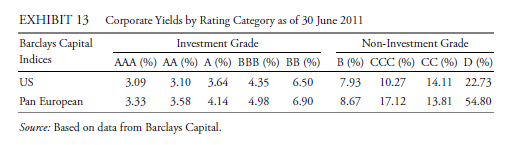

### Siguiente clase ...

Analizaremos algunos ejemplos más clásicos de estrategias con bonos. Analizaremos la curva forward a partir de la *"Curva Zero Cupón o Zero"* para analizar las expectativas de tasas de un bono y estrategias de spread.

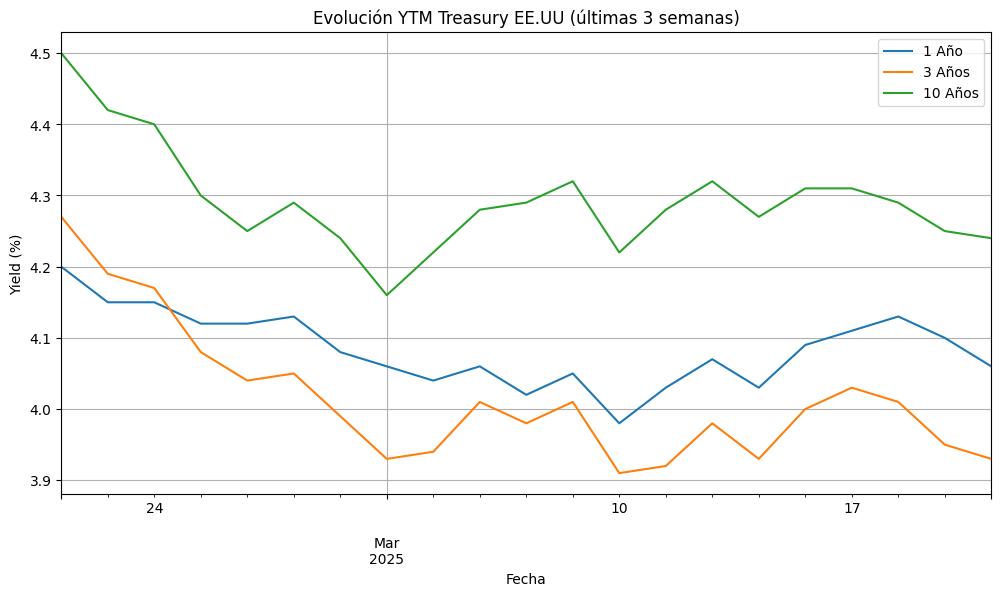

In [ ]:

df_selected.plot(figsize=(12, 6), title="Evolución YTM Treasury EE.UU (últimas 3 semanas)")
plt.xlabel("Fecha")
plt.ylabel("Yield (%)")
plt.grid(True)
plt.show()


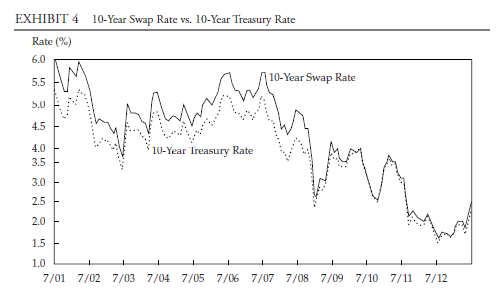

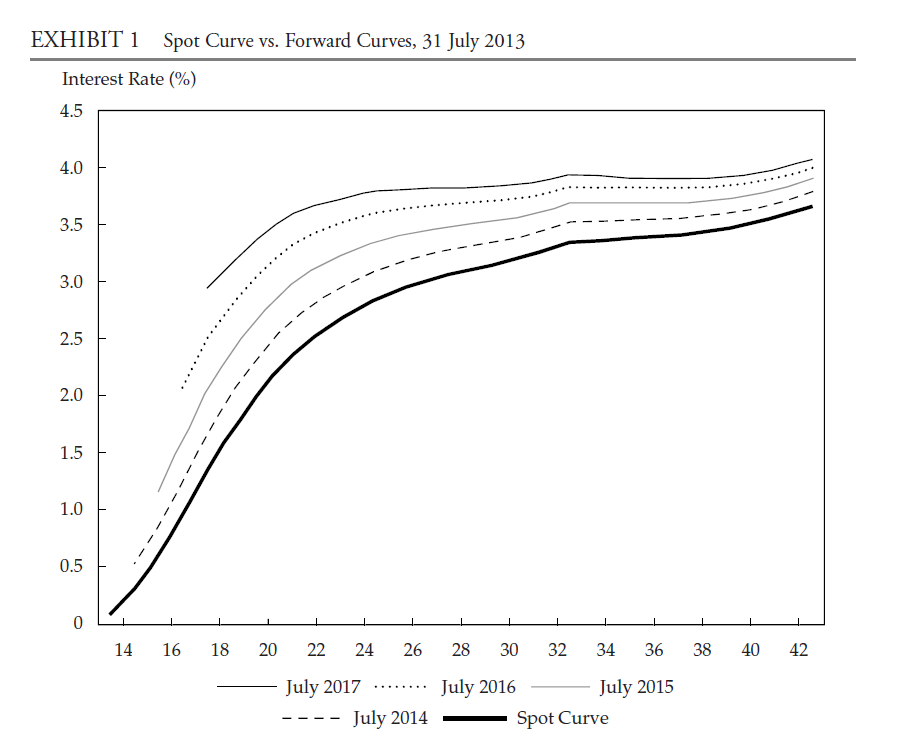